In [211]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import torch.linalg as linalg

dataset = torch.tensor([[0.,8.],[1.,8.],[2.,8.],[3.,8.],[4.,8.],
                        [0.,7.],[1.,7.],[2.,7.],[3.,7.],[4.,7.],
                        [0.,6.],[1.,6.],[2.,6.],[3.,6.],[4.,6.],
                        [0.,5.],[1.,5.],[2.,5.],[3.,5.],[4.,5.],
                        [0.,4.],[1.,4.],[2.,4.],[3.,4.],[4.,4.],
                        [0.,3.],[1.,3.],[2.,3.],[3.,3.],[4.,3.],
                        [0.,2.],[1.,2.],[2.,2.],[3.,2.],[4.,2.],
                        [0.,1.],[1.,1.],[2.,1.],[3.,1.],[4.,1.]])

labels = torch.tensor(  [0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,1.,0.,0.,
                         1.,1.,1.,0.,1.,
                         1.,1.,0.,1.,1.,
                         1.,1.,1.,1.,1.,
                         1.,1.,1.,1.,1.])

train_data = []
train_data0 = []
train_data1 = []

for i in range(len(dataset)):
   train_data.append([dataset[i], labels[i]])
   if labels[i] == 0:
      train_data0.append([dataset[i], labels[i]])
   elif labels[i] == 1:
      train_data1.append([dataset[i], labels[i]])

In [212]:
class ModelloF(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size):
        super(ModelloF, self).__init__()
        
        self.loss = torch.nn.BCEWithLogitsLoss()

        self.W0 = torch.nn.Linear(input_size, hidden_size)
        self.W1 = torch.nn.Linear(hidden_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.ReLU = torch.nn.ReLU()

        self.Sigmoid = torch.nn.Sigmoid()

        self.optimizer = torch.optim.Adam(self.parameters())
        
    def forwardL1(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2(W1 * R1(W0 * x))) 
        '''
        
        z = self.ReLU(self.W0(x))
        u = self.W1(z)
        v = self.ReLU(u)

        y = self.W2(v)

        return y, v.clone().detach() # Ritorno sa y che le v (che mi servono per la proiezione)

    def forwardL2(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2( u))
        '''

        z = self.ReLU(self.W0(x))
        u = self.W1(z)
        v = self.ReLU(u)

        v_orto = self._Projection(v, self.save_v)

        y = self.W2(v_orto)
        
        return y

    def _Projection(self, u, u_0):
        q, r = torch.linalg.qr(u_0.T, mode = 'reduced')
        
        diag = torch.diagonal(r)
        mask = torch.where(diag != 0)
        base = q.T[mask] # Base indipendenti, normalizzate
        # BASE Nx10
        P_ort = self._orthogonal_base(base)
        # Project u on them and return it
        return torch.mm(u, P_ort)

    def _orthogonal_base(self, A):
        # A = Nx10
        A = A.T
        # A = 10xN
               
        AAT = torch.matmul(A.T, A)
        # AAT = NxN

        AAT_INV = torch.linalg.solve(AAT, torch.eye(AAT.shape[0])) 
        # AAT_INV = NxN

        P_a = torch.matmul(A, AAT_INV) 
        # P_a = 10xN
        P_a = torch.matmul(P_a, A.T) 
        # P_a = 10x10
        P = torch.eye(P_a.shape[0]) - P_a 

        return P


    def forward(self, x, mode = 'inference'):
        if mode == 'inference':
            with torch.no_grad():
                y, _ = self.forwardL1(x)
            return self.Sigmoid(y)
        elif mode == 'L1':
            return self.forwardL1(x)
        elif mode == 'L2':
            return self.forwardL2(x)

    def train(self, dl, mode = 'L1'):
        for x,y in dl:
            self.optimizer.zero_grad()

            if mode == 'L1':
                y_pred, _ = self(x, mode)
            elif mode == 'L2':
                y_pred = self(x, mode)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()
                
            self.optimizer.step()
        return e.detach().numpy()


    def gen_v_y0(self, dl):
        self.save_v = None
        with torch.no_grad():
            for x,y in dl:  
                _, v = self(x, 'L1')
                if self.save_v is None:
                    self.save_v = v
                else:
                    self.save_v = torch.cat((self.save_v, v.clone().detach()), dim = 0)

In [213]:
torch.manual_seed(4242)
modello = ModelloF(2,1,20)
dl0 = torch.utils.data.DataLoader(train_data0, batch_size = 8, shuffle = True)
dl1 = torch.utils.data.DataLoader(train_data1, batch_size = 8, shuffle = True)

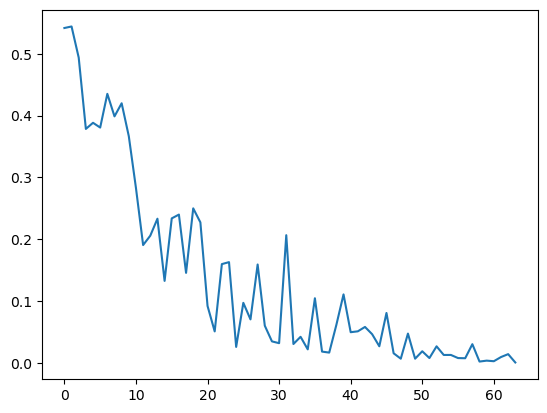

In [214]:
e = 1
err = []
while e > 1e-3:
    e = modello.train(dl1, 'L1') # Dentro dl ci deveno essere solo y == 1, ed usiamo BCEWithLogitsLoss
    err.append(e) 

plt.plot([x for x in range(len(err))], err, label = "Loss")
plt.show()

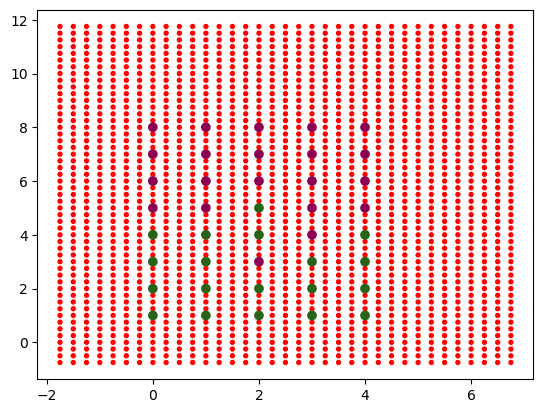

In [215]:
with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-7,7*4) for y in range(-3,12*4)]
    colori = ['blue' if p[2][0] < 0.45 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels,cmap = 'PiYG')
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione

In [216]:
print(modello(torch.tensor([0,0], dtype=torch.float)))

tensor([0.7915])


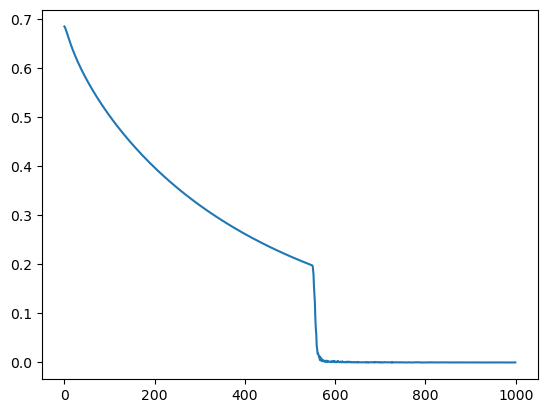

In [217]:
err = []
modello.gen_v_y0(dl1)

for _ in range(1000):
    e = modello.train(dl0, 'L2')
    err.append(e)

plt.plot([x for x in range(len(err))], err)

In [218]:
print(modello(torch.tensor([0,0], dtype = torch.float)))

tensor([0.2908])


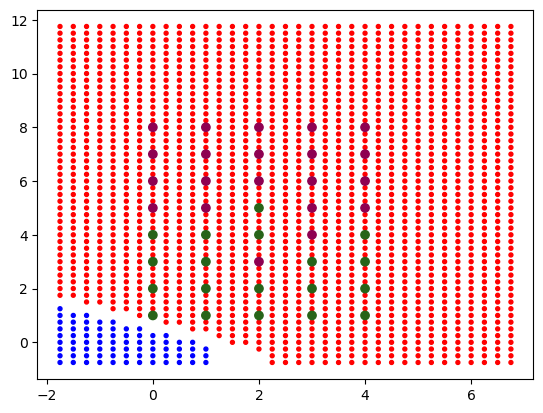

In [219]:
with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-7,7*4) for y in range(-3,12*4)]
    colori = ['blue' if p[2][0] < 0.45 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels,cmap = 'PiYG')
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione